<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods-personal/blob/main/scripts/iitd_report_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install darts
%pip install xarray[complete]
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.

In [ ]:
%pip install --quiet pytorch-lightning
%pip install --quiet tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
import xarray as xr

# Dataset


## Slicing, Optimized Station Selection and Pruning NaN cols

In [ ]:
import xarray as xr
import pandas as pd
from sklearn.impute import KNNImputer
# Load dataset
ds = xr.open_dataset("delhi_jan.nc")

# Convert to pandas DataFrame
dataframe = ds.to_dataframe()

# Find the station with the least number of NaNs
nan_counts_per_station = dataframe.groupby(level='station').apply(lambda x: x.isna().sum().sum())
station_with_least_nans = nan_counts_per_station.idxmin()

# Select data for the station with the least number of NaNs
new_dataframe = dataframe.groupby(level='station').get_group(station_with_least_nans)

# Drop columns with all NaNs
col_to_drop = ["Eth-Benzene", "MP-Xylene", "O Xylene", "TOT-RF", "RF", "VWS", "state", "city", "address", "longitude", "latitude"]
new_dataframe.drop(columns=col_to_drop, inplace=True)

# Reset the index to prepare for KNN imputation
new_dataframe_reset = new_dataframe.reset_index()

# Select columns to impute (exclude non-numeric or unwanted columns)
print(new_dataframe_reset)


               Timestamp                    station    AT     BP  Benzene  \
0    2023-01-01 00:00:00  Mandir Marg, Delhi - DPCC   8.7  978.5      6.0   
1    2023-01-01 00:15:00  Mandir Marg, Delhi - DPCC   8.7  978.5      5.9   
2    2023-01-01 00:30:00  Mandir Marg, Delhi - DPCC   9.4  978.5      5.5   
3    2023-01-01 00:45:00  Mandir Marg, Delhi - DPCC   9.6  978.5      5.7   
4    2023-01-01 01:00:00  Mandir Marg, Delhi - DPCC   9.3  978.5      5.6   
...                  ...                        ...   ...    ...      ...   
2971 2023-01-31 22:45:00  Mandir Marg, Delhi - DPCC  14.3  978.3      1.8   
2972 2023-01-31 23:00:00  Mandir Marg, Delhi - DPCC  14.1  978.3      2.0   
2973 2023-01-31 23:15:00  Mandir Marg, Delhi - DPCC  14.4  978.3      2.5   
2974 2023-01-31 23:30:00  Mandir Marg, Delhi - DPCC  14.3  978.3      3.0   
2975 2023-01-31 23:45:00  Mandir Marg, Delhi - DPCC  14.3  978.3      3.3   

       CO   NH3    NO   NO2   NOx  Ozone   PM10  PM2.5    RH   SO2    SR  \

<ipython-input-4-b6a3d8ebd618>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe.drop(columns=col_to_drop, inplace=True)


# Data Preprocessing

## KNN Imputation

In [ ]:
columns_to_impute = new_dataframe_reset.select_dtypes(include=[float, int]).columns

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer
imputed_data = knn_imputer.fit_transform(new_dataframe_reset[columns_to_impute])

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=new_dataframe_reset.index)

# Restore the original DataFrame structure
new_dataframe_reset[columns_to_impute] = imputed_df

# Set the index back to original multi-index
imputed_final_df = new_dataframe_reset.set_index(['Timestamp', 'station'])
print(imputed_final_df.apply(lambda x: x.isna().sum().sum()))
# Initialize a dictionary to store the time series DataFrames
time_series_dict = {}

# Iterate over each column except 'PM2.5' and create DataFrames with 'PM2.5' and the current column
for column in imputed_final_df.columns:

        combined_df = imputed_final_df[[column]]
        time_series_dict[column] = combined_df

# Print the individual time series
for variable, series_df in time_series_dict.items():
    print(f"Time Series {variable}:")
    print(series_df)
    print()

AT         0
BP         0
Benzene    0
CO         0
NH3        0
NO         0
NO2        0
NOx        0
Ozone      0
PM10       0
PM2.5      0
RH         0
SO2        0
SR         0
Toluene    0
WD         0
WS         0
Xylene     0
dtype: int64
Time Series AT:
                                                 AT
Timestamp           station                        
2023-01-01 00:00:00 Mandir Marg, Delhi - DPCC   8.7
2023-01-01 00:15:00 Mandir Marg, Delhi - DPCC   8.7
2023-01-01 00:30:00 Mandir Marg, Delhi - DPCC   9.4
2023-01-01 00:45:00 Mandir Marg, Delhi - DPCC   9.6
2023-01-01 01:00:00 Mandir Marg, Delhi - DPCC   9.3
...                                             ...
2023-01-31 22:45:00 Mandir Marg, Delhi - DPCC  14.3
2023-01-31 23:00:00 Mandir Marg, Delhi - DPCC  14.1
2023-01-31 23:15:00 Mandir Marg, Delhi - DPCC  14.4
2023-01-31 23:30:00 Mandir Marg, Delhi - DPCC  14.3
2023-01-31 23:45:00 Mandir Marg, Delhi - DPCC  14.3

[2976 rows x 1 columns]

Time Series BP:
                   

## Extreme Values
### Remove values by 3sigma rule

## Normalization (Standardization)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range = (0,1))

main_dict = {}
scalers = {}
main_df = mm.fit_transform(time_series_dict['PM2.5'].values)
main_df = pd.DataFrame(main_df, columns=time_series_dict['PM2.5'].columns, index=time_series_dict['PM2.5'].index)
for variable, series_df in time_series_dict.items():
    mm = MinMaxScaler(feature_range = (0,1))
    data_normalized = mm.fit_transform(series_df.values)
    data_normalized = pd.DataFrame(data_normalized, columns=series_df.columns, index=series_df.index)

    # print(data_normalized.head())

    series_df = data_normalized
    scalers[variable] = mm
    if variable!= 'PM2.5':
      combined_df = pd.concat([main_df, series_df], axis=1)
      main_dict[variable] = combined_df


print(main_dict)


{'AT':                                                   PM2.5        AT
Timestamp           station                                      
2023-01-01 00:00:00 Mandir Marg, Delhi - DPCC  0.278119  0.245791
2023-01-01 00:15:00 Mandir Marg, Delhi - DPCC  0.278119  0.245791
2023-01-01 00:30:00 Mandir Marg, Delhi - DPCC  0.278119  0.269360
2023-01-01 00:45:00 Mandir Marg, Delhi - DPCC  0.286299  0.276094
2023-01-01 01:00:00 Mandir Marg, Delhi - DPCC  0.286299  0.265993
...                                                 ...       ...
2023-01-31 22:45:00 Mandir Marg, Delhi - DPCC  0.177914  0.434343
2023-01-31 23:00:00 Mandir Marg, Delhi - DPCC  0.177914  0.427609
2023-01-31 23:15:00 Mandir Marg, Delhi - DPCC  0.177914  0.437710
2023-01-31 23:30:00 Mandir Marg, Delhi - DPCC  0.177914  0.434343
2023-01-31 23:45:00 Mandir Marg, Delhi - DPCC  0.202454  0.434343

[2976 rows x 2 columns], 'BP':                                                   PM2.5        BP
Timestamp           station          

# Models

## LSTM-RNN


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

for variable, scaled_data in main_dict.items():

    sequences = []
    labels = []
    sequence_length = 48
    num_features = 1  # Since we are only using PM2.5

    pm25_data = scaled_data['PM2.5'].values.reshape(-1, 1)  # Ensure it's a 2D array

    for i in range(len(pm25_data) - sequence_length):
        seq = pm25_data[i:i+sequence_length]
        label = pm25_data[i+sequence_length]
        sequences.append(seq)
        labels.append(label)

    # Convert to numpy arrays
    sequences = np.array(sequences)
    labels = np.array(labels)

    # Split into train and test sets
    train_size = int(0.8 * len(sequences))
    train_x, test_x = sequences[:train_size], sequences[train_size:]
    train_y, test_y = labels[:train_size], labels[train_size:]

    print("Train X shape:", train_x.shape)
    print("Train Y shape:", train_y.shape)
    print("Test X shape:", test_x.shape)
    print("Test Y shape:", test_y.shape)

    # Create the LSTM model
    model = Sequential()

    # Add LSTM layers with dropout
    model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))

    # Add a dense output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/dl/weather_prediction/best_model_weights.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(
        train_x, train_y,
        epochs=50,
        batch_size=24,
        validation_split=0.25,  # Use part of the training data as validation
        callbacks=[early_stopping, model_checkpoint]
    )



Train X shape: (2342, 48, 1)
Train Y shape: (2342, 1)
Test X shape: (586, 48, 1)
Test Y shape: (586, 1)
Epoch 1/50
74/74 [==============================] - 16s 126ms/step - loss: 0.0203 - val_loss: 0.0081
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 8s 104ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 3/50
74/74 [==============================] - 10s 130ms/step - loss: 0.0085 - val_loss: 0.0052
Epoch 4/50
74/74 [==============================] - 7s 96ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 5/50
74/74 [==============================] - 9s 120ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 6/50
74/74 [==============================] - 7s 97ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 7/50
74/74 [==============================] - 9s 127ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 8/50
74/74 [==============================] - 10s 135ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 9/50
74/74 [==============================] - 8s 103ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 10/50
74/74 [==============================] - 9s 122ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 11/50
74/74 [==============================] - 7s 97ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 12/5

NameError: name 'keras' is not defined

19/19 [==============================] - 3s 63ms/step - loss: 0.0020
Test Loss: 0.0019641369581222534


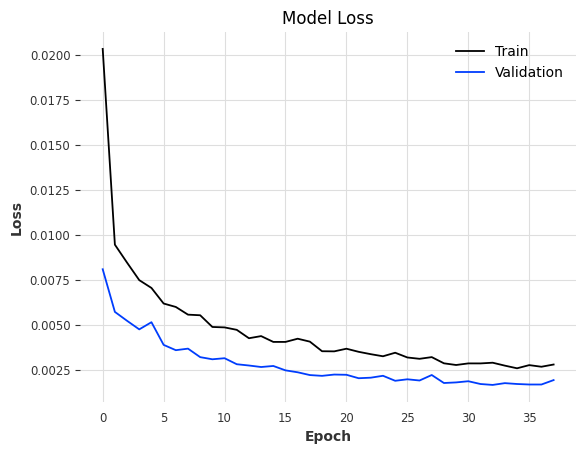

19/19 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 11.449592323576296
Mean Squared Error (MSE): 469.666389570465
Root Mean Squared Error (RMSE): 21.671787872034578


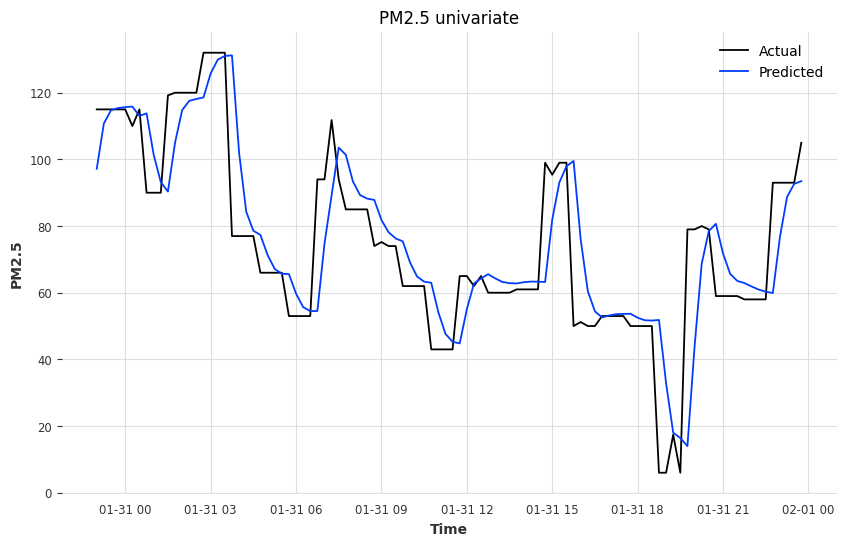

In [ ]:
# Evaluate the best model on the test set
best_model = keras.models.load_model('/content/drive/MyDrive/dl/weather_prediction/best_model_weights.h5')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict PM2.5 using the trained model
predictions = best_model.predict(test_x)
true_predict = scalers['PM2.5'].inverse_transform(predictions)
test_y = test_y.reshape(-1, 1)
true_pm = scalers['PM2.5'].inverse_transform(test_y)

# Calculate evaluation metrics
mae = mean_absolute_error(true_pm, true_predict)
mse = mean_squared_error(true_pm, true_predict)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plotting predicted and actual PM2.5
plt.figure(figsize=(10, 6))
plt.plot(scaled_data.tail(100).index.get_level_values('Timestamp'), true_pm[-100:], label='Actual')
plt.plot(scaled_data.tail(100).index.get_level_values('Timestamp'), true_predict[-100:], label='Predicted')
plt.title('PM2.5 univariate')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = self.softmax(torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model))
        out = torch.matmul(attn_weights, V)
        return out

class TimeSeriesForecast(nn.Module):
    def __init__(self, input_len, seq_len, d_model, forecast_len):
        super(TimeSeriesForecast, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model)
        self.self_attn = SelfAttention(d_model)
        self.fc = nn.Linear(input_len * d_model, forecast_len)

    def forward(self, x):
        batch_size, _, _ = x.size()
        x = x.view(batch_size, -1, self.seq_len, self.d_model)
        x = self.pos_encoder(x)
        x = self.self_attn(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

# Parameters
input_len = 48
seq_len = 8
d_model = 6
forecast_len = 12

# Create a dummy input tensor
input_tensor = torch.randn((32, input_len, d_model))  # batch_size=32, input_len=48, d_model=6

# Instantiate the model
model = TimeSeriesForecast(input_len, seq_len, d_model, forecast_len)

# Forward pass
output = model(input_tensor)
print(output.shape)  # should be [32, 12]


RuntimeError: The size of tensor a (8) must match the size of tensor b (6) at non-singleton dimension 2